In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('~/mycode/python/data_analyze/data/HR.csv')

### 独立T分布检验

In [14]:
dp_indices = df.groupby('department').indices
sales_values = df["left"].iloc[dp_indices['sales']].values
technical_values = df["left"].iloc[dp_indices["technical"]].values
ss.ttest_ind(sales_values, technical_values)


Ttest_indResult(statistic=-1.0601649378624074, pvalue=0.28910690461744781)

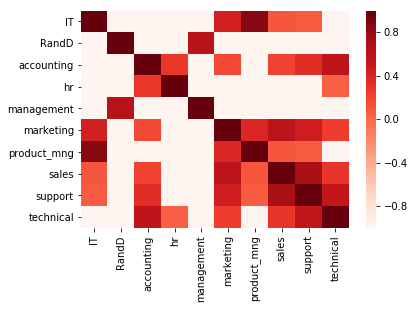

In [41]:
dp_keys = list(dp_indices.keys())
dp_t_mat = np.zeros([len(dp_keys),len(dp_keys)])
for i in range(len(dp_keys)):
    for j in range(len(dp_keys)):
        p_value = ss.ttest_ind(df["left"].iloc[dp_indices[dp_keys[i]]].values,
                              df['left'].iloc[dp_indices[dp_keys[j]]].values)[1]
        if p_value < 0.05:
            dp_t_mat[i][j] = -1
        else:
            dp_t_mat[i][j] = p_value
sns.heatmap(dp_t_mat,xticklabels = dp_keys, yticklabels = dp_keys,cmap=sns.color_palette("Reds",n_colors=256))
plt.show()

## 交叉分析-透视表

In [34]:
df
piv_tb = pd.pivot_table(df,values="left", index=["promotion_last_5years","salary"],
                       columns=["Work_accident"],
                       aggfunc=np.mean)
print(type(piv_tb))
piv_tb

<class 'pandas.core.frame.DataFrame'>


Work_accident                        0         1
promotion_last_5years salary                    
0                     high    0.082996  0.000000
                      low     0.331728  0.090020
                      medium  0.230683  0.081655
1                     high    0.000000  0.000000
                      low     0.229167  0.166667
                      medium  0.028986  0.023256

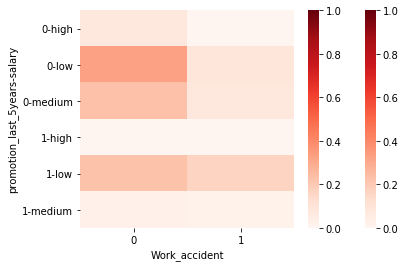

In [33]:
sns.heatmap(piv_tb,vmin=0,vmax=1,cmap=sns.color_palette("Reds",n_colors=256))
plt.show()